In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
sns.set(rc={'figure.figsize':(10,6)})

In [47]:
submissions_data = pd.read_csv("Stepik ML Contest/data/submissions_data_train.csv")
event_data = pd.read_csv("Stepik ML Contest/data/event_data_train.csv")

In [50]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,15


In [20]:
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [51]:
event_data['date'] = pd.to_datetime(event_data['timestamp'], unit='s')
event_data['day'] = event_data['date'].dt.date

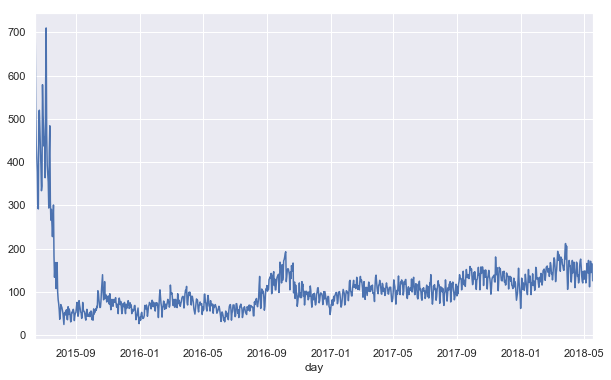

In [59]:
event_data.groupby('day').user_id.nunique().plot()

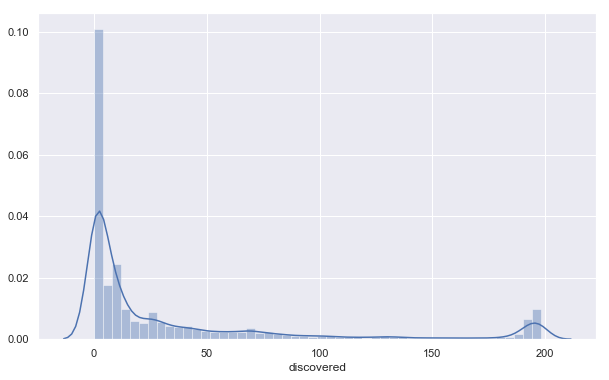

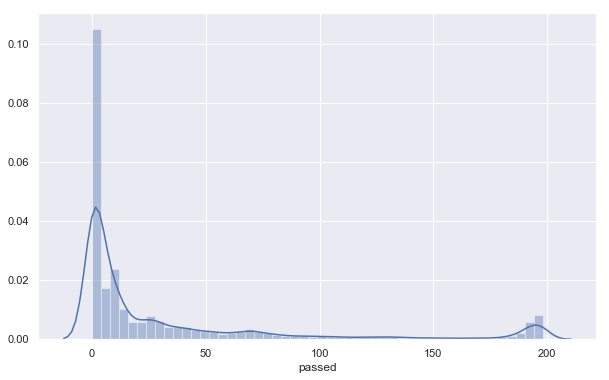

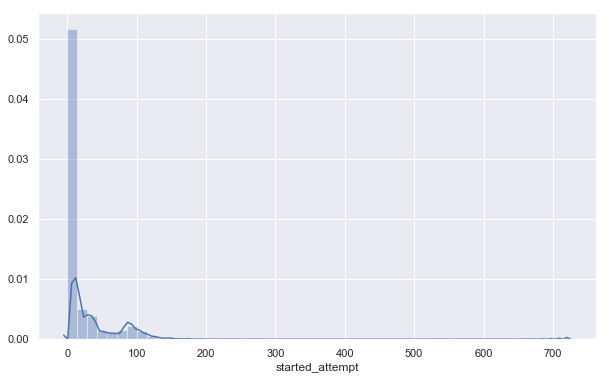

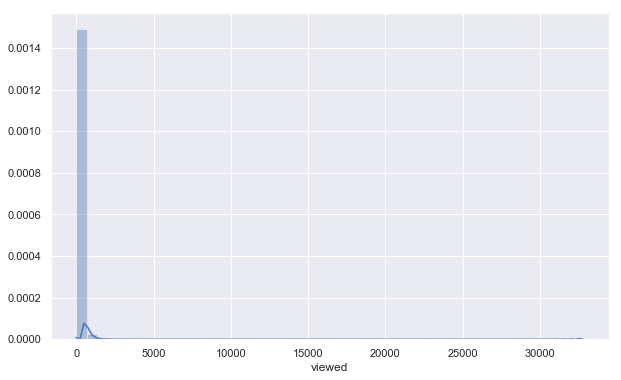

In [75]:
pivot_actions = event_data.pivot_table(index="user_id", columns="action", values="step_id", aggfunc="count", fill_value=0)
for col in pivot_actions.columns:
    plt.figure()
    sns.distplot(pivot_actions[col])
    

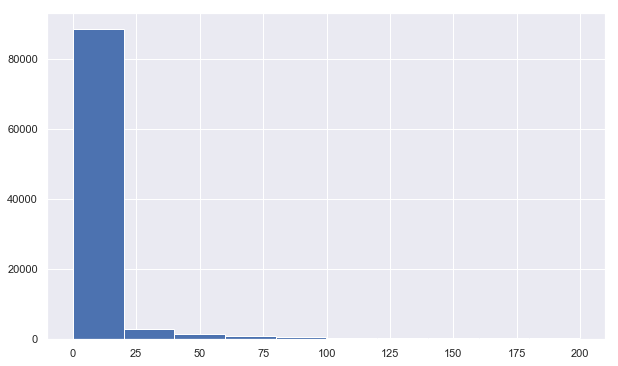

In [103]:
gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
.groupby('user_id').timestamp.apply(list)\
.apply(np.diff).values
gap_data = np.concatenate(gap_data, axis=0)/(24*60*60)
gap_data = pd.Series(gap_data, name="gaps")
gap_data[gap_data < 200].hist()

In [112]:
quantile = gap_data.quantile(0.95)*24*60*60
quantile

5163302.099999994

In [161]:
user_active = event_data.groupby('user_id').agg({'timestamp':'max'})
max_timestamp = event_data.timestamp.max()
user_active["is_gone_user"] = max_timestamp - last_event['timestamp'] > quantile
user_active = user_active.rename(columns={"timestamp":"last_timestamp"})
user_active.head()

,last_timestamp,is_gone_user
user_id,,
1,1472827464,True
2,1519226966,True
3,1444581588,True
5,1499859939,True
7,1521634660,False


In [162]:
# user_scores = pd.DataFrame()
user_scores = submissions_data.groupby('user_id').submission_status.value_counts().unstack().fillna(0)
# user_scores.submission_status = submissions_data.groupby('user_id', as_index=False)
user_scores.head()

submission_status,correct,wrong
user_id,,
2,2.0,0.0
3,29.0,23.0
5,2.0,2.0
8,9.0,21.0
14,0.0,1.0


In [175]:
users_data = user_active.merge(user_scores, on="user_id", how='outer').fillna(0)
users_data = users_data.reset_index()

In [176]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,False,0.0,0.0


In [178]:
pivot_actions = pivot_actions.reset_index()
pivot_actions.head()

action,index,user_id,discovered,passed,started_attempt,viewed
0,0,1,1,0,0,1
1,1,2,9,9,2,10
2,2,3,91,87,30,192
3,3,5,11,11,4,12
4,4,7,1,1,0,1


In [179]:
users_data = users_data.merge(pivot_actions, on="user_id", how='outer').fillna(0)

In [183]:
user_days = event_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [184]:
users_data = users_data.merge(user_days, on="user_id", how='outer').fillna(0)

In [185]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,index,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,1,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,2,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,3,11,11,4,12,2
4,7,1521634660,False,0.0,0.0,4,1,1,0,1,1


In [188]:
users_data.user_id.nunique()

19234